# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

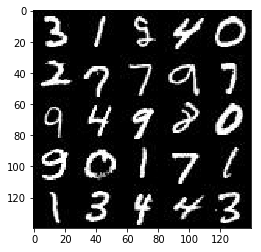

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

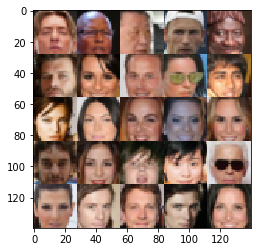

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0


/home/susana/miniconda3/envs/tensorflow/lib/python3.5/site-packages/ipykernel_launcher.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.
  


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real') 
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(dtype=tf.float32, name='learning_rate')
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha=0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 32x32x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 16x16x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 8x8x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    reuse=not is_train
    alpha=0.2
    
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*256, kernel_initializer=tf.truncated_normal_initializer(stddev=0.02))
        
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x512 256

        # Second layer
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 14x14x256 now

        #  Third Layer
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 28x28x128 now

        # This is the 4th, output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding='same')
        # 28x28xout_channel_dim now        
        
        out = tf.tanh(logits)

        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """    
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [12]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """    
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    print_every = 10
    show_every = 100
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                batch_images *= 2.0
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images})
                
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z, input_real: batch_images})

                    print("Epoch {}/{}...".format(epoch_i + 1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.0103... Generator Loss: 15.9175
Epoch 1/2... Discriminator Loss: 0.0009... Generator Loss: 12.5428
Epoch 1/2... Discriminator Loss: 0.0283... Generator Loss: 20.5857
Epoch 1/2... Discriminator Loss: 0.0011... Generator Loss: 20.2626
Epoch 1/2... Discriminator Loss: 0.0001... Generator Loss: 18.6834
Epoch 1/2... Discriminator Loss: 0.0003... Generator Loss: 16.6546
Epoch 1/2... Discriminator Loss: 0.0030... Generator Loss: 9.2384
Epoch 1/2... Discriminator Loss: 0.0002... Generator Loss: 9.8775
Epoch 1/2... Discriminator Loss: 0.0009... Generator Loss: 9.3472
Epoch 1/2... Discriminator Loss: 0.0002... Generator Loss: 9.3292


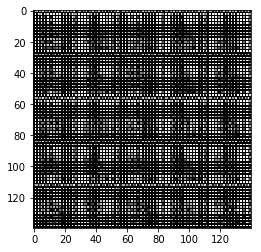

Epoch 1/2... Discriminator Loss: 0.0002... Generator Loss: 9.5975
Epoch 1/2... Discriminator Loss: 0.0002... Generator Loss: 8.9079
Epoch 1/2... Discriminator Loss: 0.0006... Generator Loss: 7.7105
Epoch 1/2... Discriminator Loss: 0.0175... Generator Loss: 4.2810
Epoch 1/2... Discriminator Loss: 0.2218... Generator Loss: 2.1321
Epoch 1/2... Discriminator Loss: 0.9582... Generator Loss: 1.7817
Epoch 1/2... Discriminator Loss: 0.0460... Generator Loss: 3.9181
Epoch 1/2... Discriminator Loss: 0.4738... Generator Loss: 2.1860
Epoch 1/2... Discriminator Loss: 0.3099... Generator Loss: 2.1218
Epoch 1/2... Discriminator Loss: 0.9346... Generator Loss: 1.7150


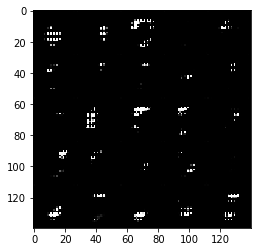

Epoch 1/2... Discriminator Loss: 1.7223... Generator Loss: 2.8861
Epoch 1/2... Discriminator Loss: 0.6896... Generator Loss: 1.2474
Epoch 1/2... Discriminator Loss: 0.9959... Generator Loss: 0.9995
Epoch 1/2... Discriminator Loss: 0.6178... Generator Loss: 1.9004
Epoch 1/2... Discriminator Loss: 0.6666... Generator Loss: 1.7360
Epoch 1/2... Discriminator Loss: 0.8879... Generator Loss: 1.6503
Epoch 1/2... Discriminator Loss: 1.5604... Generator Loss: 4.5037
Epoch 1/2... Discriminator Loss: 1.8184... Generator Loss: 0.2342
Epoch 1/2... Discriminator Loss: 0.4253... Generator Loss: 1.5799
Epoch 1/2... Discriminator Loss: 0.6080... Generator Loss: 1.3555


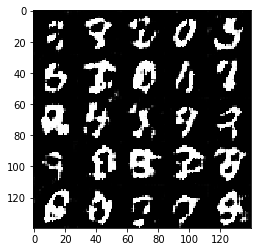

Epoch 1/2... Discriminator Loss: 1.0148... Generator Loss: 0.7707
Epoch 1/2... Discriminator Loss: 0.5783... Generator Loss: 1.4262
Epoch 1/2... Discriminator Loss: 0.8997... Generator Loss: 0.7359
Epoch 1/2... Discriminator Loss: 0.6114... Generator Loss: 1.1471
Epoch 1/2... Discriminator Loss: 1.1026... Generator Loss: 1.8871
Epoch 1/2... Discriminator Loss: 1.3735... Generator Loss: 1.6144
Epoch 1/2... Discriminator Loss: 1.4935... Generator Loss: 0.9154
Epoch 1/2... Discriminator Loss: 1.1811... Generator Loss: 1.0790
Epoch 1/2... Discriminator Loss: 0.8916... Generator Loss: 1.3322
Epoch 1/2... Discriminator Loss: 1.1749... Generator Loss: 1.5589


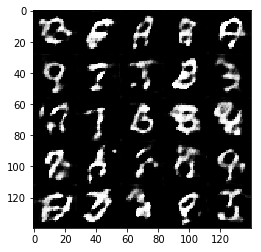

Epoch 1/2... Discriminator Loss: 1.0364... Generator Loss: 1.0221
Epoch 1/2... Discriminator Loss: 0.9047... Generator Loss: 1.0471
Epoch 1/2... Discriminator Loss: 1.1497... Generator Loss: 1.5708
Epoch 1/2... Discriminator Loss: 1.0672... Generator Loss: 1.3236
Epoch 1/2... Discriminator Loss: 0.9486... Generator Loss: 1.6021
Epoch 1/2... Discriminator Loss: 1.1655... Generator Loss: 0.7152
Epoch 1/2... Discriminator Loss: 0.9749... Generator Loss: 0.9242
Epoch 1/2... Discriminator Loss: 1.1403... Generator Loss: 0.7326
Epoch 1/2... Discriminator Loss: 0.9341... Generator Loss: 1.1959
Epoch 1/2... Discriminator Loss: 1.1296... Generator Loss: 1.1688


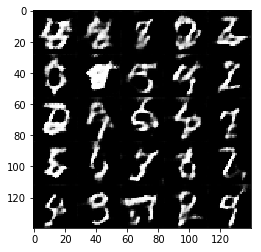

Epoch 1/2... Discriminator Loss: 1.0758... Generator Loss: 0.8987
Epoch 1/2... Discriminator Loss: 1.1199... Generator Loss: 0.6437
Epoch 1/2... Discriminator Loss: 1.0621... Generator Loss: 0.6523
Epoch 1/2... Discriminator Loss: 0.9113... Generator Loss: 0.9937
Epoch 1/2... Discriminator Loss: 1.0740... Generator Loss: 0.8051
Epoch 1/2... Discriminator Loss: 0.9470... Generator Loss: 0.8072
Epoch 1/2... Discriminator Loss: 1.1945... Generator Loss: 0.5793
Epoch 1/2... Discriminator Loss: 1.0460... Generator Loss: 1.6290
Epoch 1/2... Discriminator Loss: 1.1009... Generator Loss: 0.6677
Epoch 1/2... Discriminator Loss: 1.4086... Generator Loss: 0.6033


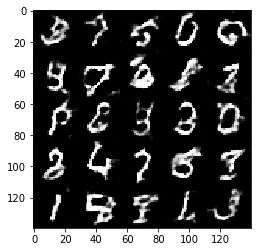

Epoch 1/2... Discriminator Loss: 1.0547... Generator Loss: 1.7164
Epoch 1/2... Discriminator Loss: 1.3870... Generator Loss: 0.3695
Epoch 1/2... Discriminator Loss: 0.9916... Generator Loss: 0.7904
Epoch 1/2... Discriminator Loss: 0.9926... Generator Loss: 1.1593
Epoch 1/2... Discriminator Loss: 1.0415... Generator Loss: 1.6714
Epoch 1/2... Discriminator Loss: 1.5758... Generator Loss: 0.2985
Epoch 1/2... Discriminator Loss: 0.9172... Generator Loss: 0.9397
Epoch 1/2... Discriminator Loss: 1.0155... Generator Loss: 0.7846
Epoch 1/2... Discriminator Loss: 1.0887... Generator Loss: 0.8198
Epoch 1/2... Discriminator Loss: 1.0637... Generator Loss: 1.5527


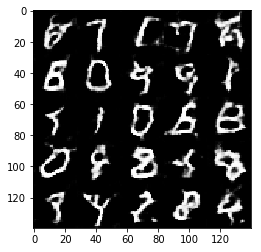

Epoch 1/2... Discriminator Loss: 1.4644... Generator Loss: 0.4058
Epoch 1/2... Discriminator Loss: 1.0404... Generator Loss: 1.5304
Epoch 1/2... Discriminator Loss: 1.0170... Generator Loss: 1.0666
Epoch 1/2... Discriminator Loss: 0.9847... Generator Loss: 1.1322
Epoch 1/2... Discriminator Loss: 1.0932... Generator Loss: 1.4057
Epoch 1/2... Discriminator Loss: 1.2303... Generator Loss: 0.5145
Epoch 1/2... Discriminator Loss: 0.8424... Generator Loss: 1.1762
Epoch 1/2... Discriminator Loss: 0.9866... Generator Loss: 0.7623
Epoch 1/2... Discriminator Loss: 1.0189... Generator Loss: 0.7510
Epoch 1/2... Discriminator Loss: 0.9800... Generator Loss: 0.8132


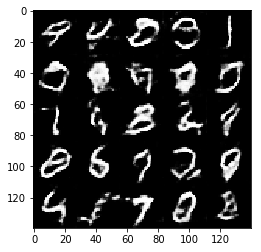

Epoch 1/2... Discriminator Loss: 1.0801... Generator Loss: 0.9042
Epoch 1/2... Discriminator Loss: 0.9547... Generator Loss: 0.8246
Epoch 1/2... Discriminator Loss: 0.8989... Generator Loss: 0.8278
Epoch 1/2... Discriminator Loss: 2.0901... Generator Loss: 0.1822
Epoch 1/2... Discriminator Loss: 0.7778... Generator Loss: 1.3345
Epoch 1/2... Discriminator Loss: 0.9640... Generator Loss: 0.7994
Epoch 1/2... Discriminator Loss: 2.3156... Generator Loss: 2.7723
Epoch 1/2... Discriminator Loss: 1.0584... Generator Loss: 0.8570
Epoch 1/2... Discriminator Loss: 0.8601... Generator Loss: 0.8511
Epoch 1/2... Discriminator Loss: 0.9179... Generator Loss: 1.0529


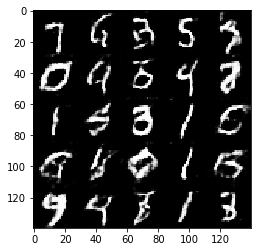

Epoch 1/2... Discriminator Loss: 0.9019... Generator Loss: 1.6377
Epoch 1/2... Discriminator Loss: 1.3563... Generator Loss: 1.5650
Epoch 1/2... Discriminator Loss: 0.9875... Generator Loss: 1.2712
Epoch 2/2... Discriminator Loss: 1.3526... Generator Loss: 0.4340
Epoch 2/2... Discriminator Loss: 1.4650... Generator Loss: 0.3825
Epoch 2/2... Discriminator Loss: 1.0950... Generator Loss: 1.5785
Epoch 2/2... Discriminator Loss: 1.0286... Generator Loss: 1.0875
Epoch 2/2... Discriminator Loss: 1.3078... Generator Loss: 2.6124
Epoch 2/2... Discriminator Loss: 1.1793... Generator Loss: 0.6077
Epoch 2/2... Discriminator Loss: 1.1491... Generator Loss: 0.5904


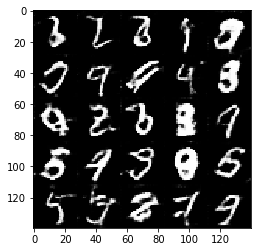

Epoch 2/2... Discriminator Loss: 0.8994... Generator Loss: 1.1618
Epoch 2/2... Discriminator Loss: 1.1541... Generator Loss: 0.9810
Epoch 2/2... Discriminator Loss: 1.3192... Generator Loss: 0.4716
Epoch 2/2... Discriminator Loss: 1.0874... Generator Loss: 0.6746
Epoch 2/2... Discriminator Loss: 1.0945... Generator Loss: 0.6418
Epoch 2/2... Discriminator Loss: 0.9095... Generator Loss: 0.9856
Epoch 2/2... Discriminator Loss: 1.2073... Generator Loss: 1.9259
Epoch 2/2... Discriminator Loss: 1.0958... Generator Loss: 0.6308
Epoch 2/2... Discriminator Loss: 1.2562... Generator Loss: 1.4395
Epoch 2/2... Discriminator Loss: 0.9570... Generator Loss: 1.0534


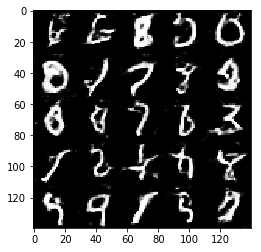

Epoch 2/2... Discriminator Loss: 1.0391... Generator Loss: 1.3143
Epoch 2/2... Discriminator Loss: 1.1285... Generator Loss: 0.5858
Epoch 2/2... Discriminator Loss: 1.0788... Generator Loss: 1.9679
Epoch 2/2... Discriminator Loss: 1.1211... Generator Loss: 0.6061
Epoch 2/2... Discriminator Loss: 1.1185... Generator Loss: 2.1442
Epoch 2/2... Discriminator Loss: 1.1315... Generator Loss: 0.6163
Epoch 2/2... Discriminator Loss: 1.3538... Generator Loss: 0.4830
Epoch 2/2... Discriminator Loss: 1.5566... Generator Loss: 0.3501
Epoch 2/2... Discriminator Loss: 0.9632... Generator Loss: 0.8355
Epoch 2/2... Discriminator Loss: 0.9565... Generator Loss: 0.8614


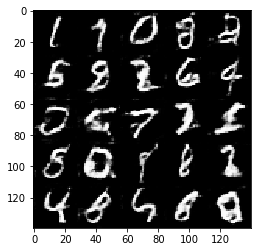

Epoch 2/2... Discriminator Loss: 0.9306... Generator Loss: 0.8373
Epoch 2/2... Discriminator Loss: 1.0675... Generator Loss: 1.6786
Epoch 2/2... Discriminator Loss: 0.7781... Generator Loss: 1.5064
Epoch 2/2... Discriminator Loss: 1.0976... Generator Loss: 0.7743
Epoch 2/2... Discriminator Loss: 1.2280... Generator Loss: 0.7219
Epoch 2/2... Discriminator Loss: 1.5351... Generator Loss: 2.0941
Epoch 2/2... Discriminator Loss: 1.2114... Generator Loss: 0.6741
Epoch 2/2... Discriminator Loss: 1.2900... Generator Loss: 0.5083
Epoch 2/2... Discriminator Loss: 0.7936... Generator Loss: 1.1144
Epoch 2/2... Discriminator Loss: 1.4934... Generator Loss: 0.3719


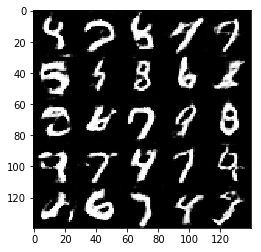

Epoch 2/2... Discriminator Loss: 1.5130... Generator Loss: 0.3485
Epoch 2/2... Discriminator Loss: 0.9370... Generator Loss: 0.8556
Epoch 2/2... Discriminator Loss: 1.2296... Generator Loss: 0.4690
Epoch 2/2... Discriminator Loss: 1.3237... Generator Loss: 0.4757
Epoch 2/2... Discriminator Loss: 1.2995... Generator Loss: 0.5073
Epoch 2/2... Discriminator Loss: 1.1586... Generator Loss: 1.3074
Epoch 2/2... Discriminator Loss: 1.2934... Generator Loss: 0.5860
Epoch 2/2... Discriminator Loss: 1.0711... Generator Loss: 0.9004
Epoch 2/2... Discriminator Loss: 0.8814... Generator Loss: 1.1010
Epoch 2/2... Discriminator Loss: 0.9639... Generator Loss: 1.0836


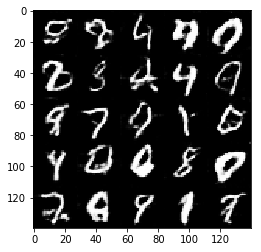

Epoch 2/2... Discriminator Loss: 0.9737... Generator Loss: 0.8527
Epoch 2/2... Discriminator Loss: 0.9404... Generator Loss: 1.1846
Epoch 2/2... Discriminator Loss: 1.1592... Generator Loss: 0.8794
Epoch 2/2... Discriminator Loss: 1.0318... Generator Loss: 1.8273
Epoch 2/2... Discriminator Loss: 0.8865... Generator Loss: 0.8198
Epoch 2/2... Discriminator Loss: 1.5012... Generator Loss: 0.3949
Epoch 2/2... Discriminator Loss: 1.0496... Generator Loss: 0.9037
Epoch 2/2... Discriminator Loss: 0.9975... Generator Loss: 0.7581
Epoch 2/2... Discriminator Loss: 0.8748... Generator Loss: 0.9364
Epoch 2/2... Discriminator Loss: 1.0789... Generator Loss: 0.6123


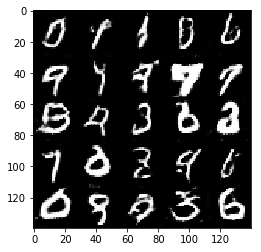

Epoch 2/2... Discriminator Loss: 0.8510... Generator Loss: 0.9227
Epoch 2/2... Discriminator Loss: 0.8830... Generator Loss: 1.0248
Epoch 2/2... Discriminator Loss: 0.7959... Generator Loss: 0.9587
Epoch 2/2... Discriminator Loss: 0.7105... Generator Loss: 1.4377
Epoch 2/2... Discriminator Loss: 1.6737... Generator Loss: 1.9763
Epoch 2/2... Discriminator Loss: 1.2543... Generator Loss: 0.5163
Epoch 2/2... Discriminator Loss: 1.1117... Generator Loss: 0.6639
Epoch 2/2... Discriminator Loss: 0.9473... Generator Loss: 0.8999
Epoch 2/2... Discriminator Loss: 1.5925... Generator Loss: 0.3605
Epoch 2/2... Discriminator Loss: 0.7367... Generator Loss: 1.0176


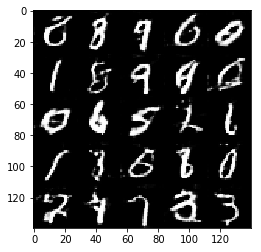

Epoch 2/2... Discriminator Loss: 0.6867... Generator Loss: 1.3406
Epoch 2/2... Discriminator Loss: 1.2621... Generator Loss: 0.5049
Epoch 2/2... Discriminator Loss: 0.9925... Generator Loss: 0.7768
Epoch 2/2... Discriminator Loss: 0.7180... Generator Loss: 1.2142
Epoch 2/2... Discriminator Loss: 0.9598... Generator Loss: 0.9524
Epoch 2/2... Discriminator Loss: 0.7979... Generator Loss: 1.0082
Epoch 2/2... Discriminator Loss: 0.8522... Generator Loss: 1.5825
Epoch 2/2... Discriminator Loss: 0.8210... Generator Loss: 1.0028
Epoch 2/2... Discriminator Loss: 0.6554... Generator Loss: 1.6444
Epoch 2/2... Discriminator Loss: 0.7079... Generator Loss: 1.1325


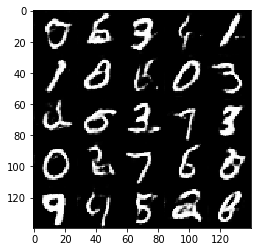

Epoch 2/2... Discriminator Loss: 1.1055... Generator Loss: 0.6260
Epoch 2/2... Discriminator Loss: 0.8870... Generator Loss: 0.8947
Epoch 2/2... Discriminator Loss: 0.8576... Generator Loss: 1.9203
Epoch 2/2... Discriminator Loss: 1.1836... Generator Loss: 1.4443
Epoch 2/2... Discriminator Loss: 0.9479... Generator Loss: 1.0050
Epoch 2/2... Discriminator Loss: 0.8036... Generator Loss: 1.1333
Epoch 2/2... Discriminator Loss: 0.9114... Generator Loss: 1.1004
Epoch 2/2... Discriminator Loss: 0.8141... Generator Loss: 1.3018
Epoch 2/2... Discriminator Loss: 1.4449... Generator Loss: 0.3790
Epoch 2/2... Discriminator Loss: 0.9324... Generator Loss: 0.7283


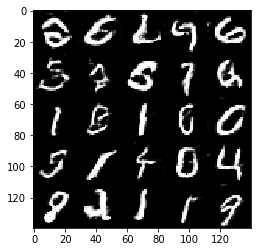

Epoch 2/2... Discriminator Loss: 1.3026... Generator Loss: 2.1225
Epoch 2/2... Discriminator Loss: 0.6564... Generator Loss: 1.7898
Epoch 2/2... Discriminator Loss: 1.0972... Generator Loss: 0.6206
Epoch 2/2... Discriminator Loss: 0.9480... Generator Loss: 0.7346
Epoch 2/2... Discriminator Loss: 0.8881... Generator Loss: 1.1901
Epoch 2/2... Discriminator Loss: 1.7772... Generator Loss: 3.2820
Epoch 2/2... Discriminator Loss: 1.0162... Generator Loss: 1.1166


In [14]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.5

#tf.reset_default_graph()

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.0038... Generator Loss: 15.0930
Epoch 1/1... Discriminator Loss: 0.6863... Generator Loss: 5.8289
Epoch 1/1... Discriminator Loss: 1.4817... Generator Loss: 5.5636
Epoch 1/1... Discriminator Loss: 0.2848... Generator Loss: 1.9597
Epoch 1/1... Discriminator Loss: 0.5652... Generator Loss: 2.0504
Epoch 1/1... Discriminator Loss: 2.5733... Generator Loss: 0.1729
Epoch 1/1... Discriminator Loss: 0.7616... Generator Loss: 1.7362
Epoch 1/1... Discriminator Loss: 0.5922... Generator Loss: 2.9418
Epoch 1/1... Discriminator Loss: 0.1800... Generator Loss: 3.0858
Epoch 1/1... Discriminator Loss: 0.2340... Generator Loss: 2.8112


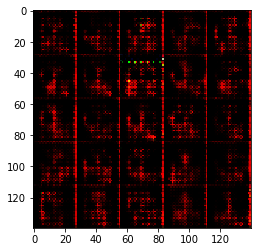

Epoch 1/1... Discriminator Loss: 0.1571... Generator Loss: 5.3249
Epoch 1/1... Discriminator Loss: 0.0563... Generator Loss: 4.5816
Epoch 1/1... Discriminator Loss: 1.0768... Generator Loss: 0.9517
Epoch 1/1... Discriminator Loss: 0.0365... Generator Loss: 3.9931
Epoch 1/1... Discriminator Loss: 0.0522... Generator Loss: 4.5176
Epoch 1/1... Discriminator Loss: 0.0831... Generator Loss: 6.4954
Epoch 1/1... Discriminator Loss: 1.0418... Generator Loss: 6.4620
Epoch 1/1... Discriminator Loss: 1.7303... Generator Loss: 0.4025
Epoch 1/1... Discriminator Loss: 1.0886... Generator Loss: 0.8972
Epoch 1/1... Discriminator Loss: 1.4764... Generator Loss: 0.7237


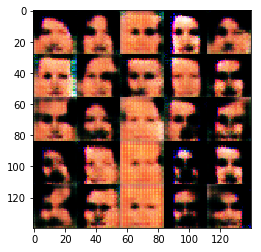

Epoch 1/1... Discriminator Loss: 1.3207... Generator Loss: 0.4781
Epoch 1/1... Discriminator Loss: 1.6252... Generator Loss: 0.3847
Epoch 1/1... Discriminator Loss: 1.0690... Generator Loss: 0.8295
Epoch 1/1... Discriminator Loss: 1.1584... Generator Loss: 2.3001
Epoch 1/1... Discriminator Loss: 1.0764... Generator Loss: 0.8906
Epoch 1/1... Discriminator Loss: 1.0448... Generator Loss: 1.2838
Epoch 1/1... Discriminator Loss: 1.0504... Generator Loss: 0.6987
Epoch 1/1... Discriminator Loss: 1.4024... Generator Loss: 0.8465
Epoch 1/1... Discriminator Loss: 1.1232... Generator Loss: 1.6531
Epoch 1/1... Discriminator Loss: 0.5359... Generator Loss: 2.3949


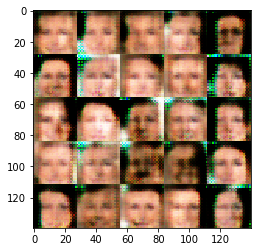

Epoch 1/1... Discriminator Loss: 1.0381... Generator Loss: 1.5716
Epoch 1/1... Discriminator Loss: 0.7973... Generator Loss: 0.9320
Epoch 1/1... Discriminator Loss: 1.6301... Generator Loss: 0.3877
Epoch 1/1... Discriminator Loss: 1.0049... Generator Loss: 0.9043
Epoch 1/1... Discriminator Loss: 1.2107... Generator Loss: 1.0786
Epoch 1/1... Discriminator Loss: 1.3825... Generator Loss: 2.1446
Epoch 1/1... Discriminator Loss: 0.8146... Generator Loss: 1.5204
Epoch 1/1... Discriminator Loss: 1.4896... Generator Loss: 1.4830
Epoch 1/1... Discriminator Loss: 2.2633... Generator Loss: 0.1626
Epoch 1/1... Discriminator Loss: 1.2097... Generator Loss: 0.4882


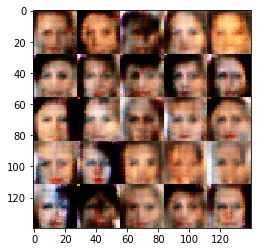

Epoch 1/1... Discriminator Loss: 1.0500... Generator Loss: 0.7213
Epoch 1/1... Discriminator Loss: 0.6878... Generator Loss: 1.0177
Epoch 1/1... Discriminator Loss: 1.2073... Generator Loss: 1.1113
Epoch 1/1... Discriminator Loss: 1.2804... Generator Loss: 0.4976
Epoch 1/1... Discriminator Loss: 0.9750... Generator Loss: 1.1930
Epoch 1/1... Discriminator Loss: 0.9257... Generator Loss: 0.9930
Epoch 1/1... Discriminator Loss: 1.4120... Generator Loss: 0.4977
Epoch 1/1... Discriminator Loss: 1.1821... Generator Loss: 0.5542
Epoch 1/1... Discriminator Loss: 1.6463... Generator Loss: 0.2681
Epoch 1/1... Discriminator Loss: 1.7167... Generator Loss: 0.2501


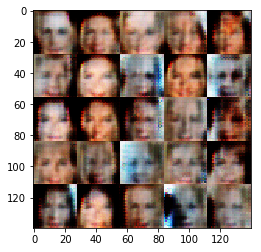

Epoch 1/1... Discriminator Loss: 1.5760... Generator Loss: 1.3142
Epoch 1/1... Discriminator Loss: 0.7935... Generator Loss: 1.3043
Epoch 1/1... Discriminator Loss: 1.0201... Generator Loss: 0.8871
Epoch 1/1... Discriminator Loss: 2.0035... Generator Loss: 0.1809
Epoch 1/1... Discriminator Loss: 0.8407... Generator Loss: 0.9331
Epoch 1/1... Discriminator Loss: 0.5709... Generator Loss: 1.8508
Epoch 1/1... Discriminator Loss: 0.9884... Generator Loss: 0.6716
Epoch 1/1... Discriminator Loss: 1.2702... Generator Loss: 0.6973
Epoch 1/1... Discriminator Loss: 1.3222... Generator Loss: 0.4982
Epoch 1/1... Discriminator Loss: 1.3444... Generator Loss: 0.5875


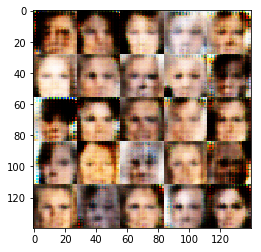

Epoch 1/1... Discriminator Loss: 1.0079... Generator Loss: 1.0772
Epoch 1/1... Discriminator Loss: 1.2132... Generator Loss: 0.5203
Epoch 1/1... Discriminator Loss: 1.2968... Generator Loss: 0.5103
Epoch 1/1... Discriminator Loss: 0.9970... Generator Loss: 1.4220
Epoch 1/1... Discriminator Loss: 1.2782... Generator Loss: 0.8482
Epoch 1/1... Discriminator Loss: 1.2323... Generator Loss: 0.6431
Epoch 1/1... Discriminator Loss: 1.0526... Generator Loss: 0.8692
Epoch 1/1... Discriminator Loss: 1.4288... Generator Loss: 1.2418
Epoch 1/1... Discriminator Loss: 1.0557... Generator Loss: 0.9008
Epoch 1/1... Discriminator Loss: 1.5226... Generator Loss: 0.4622


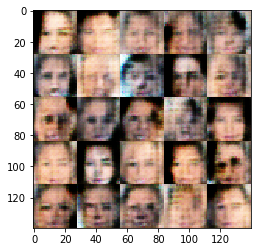

Epoch 1/1... Discriminator Loss: 1.2273... Generator Loss: 0.5002
Epoch 1/1... Discriminator Loss: 0.3204... Generator Loss: 2.2231
Epoch 1/1... Discriminator Loss: 1.2416... Generator Loss: 1.6965
Epoch 1/1... Discriminator Loss: 1.0851... Generator Loss: 0.7540
Epoch 1/1... Discriminator Loss: 1.3609... Generator Loss: 0.4717
Epoch 1/1... Discriminator Loss: 1.0436... Generator Loss: 0.8066
Epoch 1/1... Discriminator Loss: 1.6545... Generator Loss: 0.3079
Epoch 1/1... Discriminator Loss: 1.4799... Generator Loss: 0.6742
Epoch 1/1... Discriminator Loss: 1.0305... Generator Loss: 0.7066
Epoch 1/1... Discriminator Loss: 1.8108... Generator Loss: 0.2257


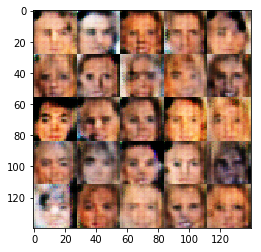

Epoch 1/1... Discriminator Loss: 1.4382... Generator Loss: 0.6140
Epoch 1/1... Discriminator Loss: 1.0238... Generator Loss: 0.7705
Epoch 1/1... Discriminator Loss: 1.0702... Generator Loss: 0.7424
Epoch 1/1... Discriminator Loss: 0.3322... Generator Loss: 2.2837
Epoch 1/1... Discriminator Loss: 1.0659... Generator Loss: 0.6049
Epoch 1/1... Discriminator Loss: 0.7088... Generator Loss: 1.2329
Epoch 1/1... Discriminator Loss: 0.8374... Generator Loss: 1.0562
Epoch 1/1... Discriminator Loss: 1.7715... Generator Loss: 0.4945
Epoch 1/1... Discriminator Loss: 0.7643... Generator Loss: 1.7440
Epoch 1/1... Discriminator Loss: 1.5049... Generator Loss: 1.7234


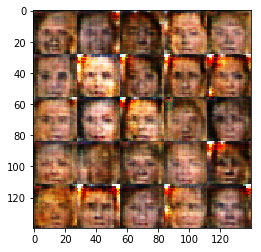

Epoch 1/1... Discriminator Loss: 0.9622... Generator Loss: 1.3254
Epoch 1/1... Discriminator Loss: 0.9177... Generator Loss: 1.0492
Epoch 1/1... Discriminator Loss: 1.5846... Generator Loss: 2.2726
Epoch 1/1... Discriminator Loss: 1.4292... Generator Loss: 0.5175
Epoch 1/1... Discriminator Loss: 1.2539... Generator Loss: 0.6941
Epoch 1/1... Discriminator Loss: 1.4055... Generator Loss: 0.5459
Epoch 1/1... Discriminator Loss: 1.3977... Generator Loss: 0.5659
Epoch 1/1... Discriminator Loss: 1.4860... Generator Loss: 0.6526
Epoch 1/1... Discriminator Loss: 1.2722... Generator Loss: 0.5654
Epoch 1/1... Discriminator Loss: 1.3140... Generator Loss: 0.6927


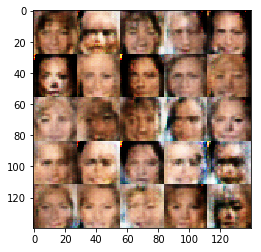

Epoch 1/1... Discriminator Loss: 1.1521... Generator Loss: 0.7990
Epoch 1/1... Discriminator Loss: 1.3128... Generator Loss: 0.7364
Epoch 1/1... Discriminator Loss: 1.1927... Generator Loss: 1.1271
Epoch 1/1... Discriminator Loss: 1.5319... Generator Loss: 0.5145
Epoch 1/1... Discriminator Loss: 1.2403... Generator Loss: 1.1693
Epoch 1/1... Discriminator Loss: 1.2311... Generator Loss: 0.5900
Epoch 1/1... Discriminator Loss: 1.4640... Generator Loss: 0.8934
Epoch 1/1... Discriminator Loss: 1.5205... Generator Loss: 0.4031
Epoch 1/1... Discriminator Loss: 1.4586... Generator Loss: 0.4655
Epoch 1/1... Discriminator Loss: 1.4547... Generator Loss: 0.6694


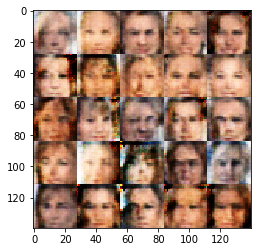

Epoch 1/1... Discriminator Loss: 1.2823... Generator Loss: 0.6756
Epoch 1/1... Discriminator Loss: 1.2469... Generator Loss: 0.8029
Epoch 1/1... Discriminator Loss: 1.3588... Generator Loss: 0.4250
Epoch 1/1... Discriminator Loss: 1.1642... Generator Loss: 0.6365
Epoch 1/1... Discriminator Loss: 1.0648... Generator Loss: 0.9247
Epoch 1/1... Discriminator Loss: 1.1074... Generator Loss: 0.9589
Epoch 1/1... Discriminator Loss: 1.5767... Generator Loss: 0.4368
Epoch 1/1... Discriminator Loss: 1.3226... Generator Loss: 0.7888
Epoch 1/1... Discriminator Loss: 1.1023... Generator Loss: 0.9221
Epoch 1/1... Discriminator Loss: 1.3006... Generator Loss: 0.5333


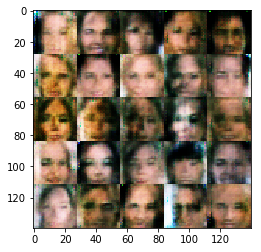

Epoch 1/1... Discriminator Loss: 1.3772... Generator Loss: 0.5703
Epoch 1/1... Discriminator Loss: 1.5211... Generator Loss: 0.4660
Epoch 1/1... Discriminator Loss: 1.2840... Generator Loss: 0.9079
Epoch 1/1... Discriminator Loss: 1.1833... Generator Loss: 0.6949
Epoch 1/1... Discriminator Loss: 1.5889... Generator Loss: 1.2623
Epoch 1/1... Discriminator Loss: 1.3776... Generator Loss: 0.5663
Epoch 1/1... Discriminator Loss: 1.6975... Generator Loss: 1.2073
Epoch 1/1... Discriminator Loss: 1.2490... Generator Loss: 0.6629
Epoch 1/1... Discriminator Loss: 1.1677... Generator Loss: 0.6651
Epoch 1/1... Discriminator Loss: 1.3101... Generator Loss: 0.9146


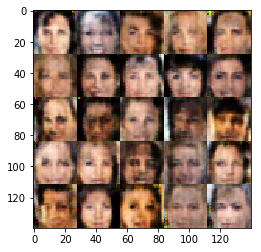

Epoch 1/1... Discriminator Loss: 1.3335... Generator Loss: 0.8409
Epoch 1/1... Discriminator Loss: 1.3920... Generator Loss: 0.6640
Epoch 1/1... Discriminator Loss: 1.1016... Generator Loss: 1.4040
Epoch 1/1... Discriminator Loss: 1.2313... Generator Loss: 0.5337
Epoch 1/1... Discriminator Loss: 1.6341... Generator Loss: 0.2840
Epoch 1/1... Discriminator Loss: 1.2275... Generator Loss: 0.9366
Epoch 1/1... Discriminator Loss: 0.8514... Generator Loss: 1.0746
Epoch 1/1... Discriminator Loss: 0.8724... Generator Loss: 0.8240
Epoch 1/1... Discriminator Loss: 0.9954... Generator Loss: 0.7486
Epoch 1/1... Discriminator Loss: 1.1378... Generator Loss: 0.6593


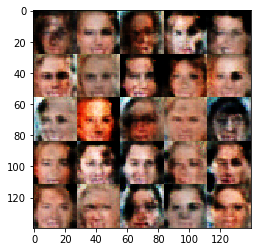

Epoch 1/1... Discriminator Loss: 1.4502... Generator Loss: 0.4866
Epoch 1/1... Discriminator Loss: 1.3830... Generator Loss: 0.5564
Epoch 1/1... Discriminator Loss: 1.2290... Generator Loss: 0.8051
Epoch 1/1... Discriminator Loss: 1.3717... Generator Loss: 1.2848
Epoch 1/1... Discriminator Loss: 1.6374... Generator Loss: 1.8871
Epoch 1/1... Discriminator Loss: 1.5699... Generator Loss: 1.8891
Epoch 1/1... Discriminator Loss: 1.3760... Generator Loss: 0.5580
Epoch 1/1... Discriminator Loss: 1.2304... Generator Loss: 0.8599
Epoch 1/1... Discriminator Loss: 1.2233... Generator Loss: 0.8846
Epoch 1/1... Discriminator Loss: 1.4354... Generator Loss: 0.3970


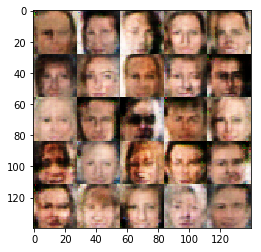

Epoch 1/1... Discriminator Loss: 1.2591... Generator Loss: 1.0200
Epoch 1/1... Discriminator Loss: 1.3971... Generator Loss: 0.6846
Epoch 1/1... Discriminator Loss: 1.6670... Generator Loss: 0.2657
Epoch 1/1... Discriminator Loss: 1.9324... Generator Loss: 1.5322
Epoch 1/1... Discriminator Loss: 1.4387... Generator Loss: 0.8371
Epoch 1/1... Discriminator Loss: 1.4043... Generator Loss: 0.4614
Epoch 1/1... Discriminator Loss: 1.6319... Generator Loss: 0.3141
Epoch 1/1... Discriminator Loss: 1.1690... Generator Loss: 0.6668
Epoch 1/1... Discriminator Loss: 1.1421... Generator Loss: 0.7182
Epoch 1/1... Discriminator Loss: 1.3172... Generator Loss: 1.4041


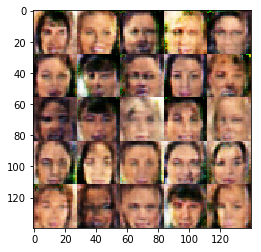

Epoch 1/1... Discriminator Loss: 1.3066... Generator Loss: 0.7355
Epoch 1/1... Discriminator Loss: 1.2230... Generator Loss: 0.8016
Epoch 1/1... Discriminator Loss: 1.3309... Generator Loss: 0.6788
Epoch 1/1... Discriminator Loss: 1.1362... Generator Loss: 0.9572
Epoch 1/1... Discriminator Loss: 1.3090... Generator Loss: 0.4350
Epoch 1/1... Discriminator Loss: 1.3657... Generator Loss: 0.7573
Epoch 1/1... Discriminator Loss: 1.1701... Generator Loss: 0.8156
Epoch 1/1... Discriminator Loss: 1.1998... Generator Loss: 0.5856
Epoch 1/1... Discriminator Loss: 1.5063... Generator Loss: 0.4317
Epoch 1/1... Discriminator Loss: 1.2416... Generator Loss: 0.8230


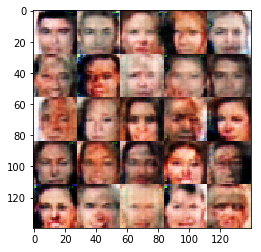

Epoch 1/1... Discriminator Loss: 1.1868... Generator Loss: 0.6650
Epoch 1/1... Discriminator Loss: 1.4180... Generator Loss: 0.4856
Epoch 1/1... Discriminator Loss: 1.3998... Generator Loss: 0.5349
Epoch 1/1... Discriminator Loss: 1.2169... Generator Loss: 0.7380
Epoch 1/1... Discriminator Loss: 1.4159... Generator Loss: 0.6217
Epoch 1/1... Discriminator Loss: 1.2482... Generator Loss: 0.8799
Epoch 1/1... Discriminator Loss: 1.4489... Generator Loss: 0.4145
Epoch 1/1... Discriminator Loss: 1.0913... Generator Loss: 0.7073
Epoch 1/1... Discriminator Loss: 1.1288... Generator Loss: 0.6041
Epoch 1/1... Discriminator Loss: 1.3642... Generator Loss: 0.7140


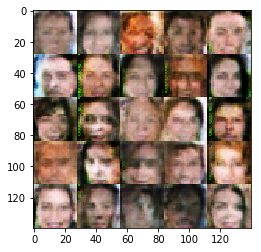

Epoch 1/1... Discriminator Loss: 1.5175... Generator Loss: 0.4376
Epoch 1/1... Discriminator Loss: 1.2240... Generator Loss: 0.8839
Epoch 1/1... Discriminator Loss: 1.3602... Generator Loss: 0.9608
Epoch 1/1... Discriminator Loss: 1.2753... Generator Loss: 0.7356
Epoch 1/1... Discriminator Loss: 1.2442... Generator Loss: 0.7104
Epoch 1/1... Discriminator Loss: 1.6692... Generator Loss: 0.2987
Epoch 1/1... Discriminator Loss: 1.2745... Generator Loss: 0.7080
Epoch 1/1... Discriminator Loss: 1.2112... Generator Loss: 0.6602
Epoch 1/1... Discriminator Loss: 1.4251... Generator Loss: 0.7460
Epoch 1/1... Discriminator Loss: 1.4416... Generator Loss: 0.6430


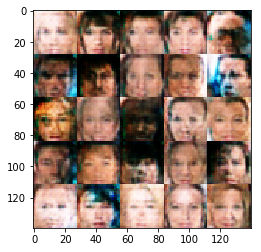

Epoch 1/1... Discriminator Loss: 1.3842... Generator Loss: 0.4590
Epoch 1/1... Discriminator Loss: 1.2877... Generator Loss: 0.5971
Epoch 1/1... Discriminator Loss: 1.6273... Generator Loss: 0.3321
Epoch 1/1... Discriminator Loss: 1.4734... Generator Loss: 0.5444
Epoch 1/1... Discriminator Loss: 1.1188... Generator Loss: 0.8302
Epoch 1/1... Discriminator Loss: 1.3502... Generator Loss: 0.5285
Epoch 1/1... Discriminator Loss: 1.1998... Generator Loss: 0.7076
Epoch 1/1... Discriminator Loss: 1.2481... Generator Loss: 0.9144
Epoch 1/1... Discriminator Loss: 1.3226... Generator Loss: 0.5318
Epoch 1/1... Discriminator Loss: 1.2589... Generator Loss: 0.7765


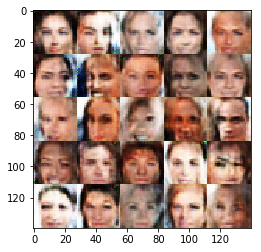

Epoch 1/1... Discriminator Loss: 0.7449... Generator Loss: 1.3482
Epoch 1/1... Discriminator Loss: 1.4204... Generator Loss: 0.9064
Epoch 1/1... Discriminator Loss: 1.3764... Generator Loss: 0.7476
Epoch 1/1... Discriminator Loss: 1.3303... Generator Loss: 0.6332
Epoch 1/1... Discriminator Loss: 1.2650... Generator Loss: 0.7428
Epoch 1/1... Discriminator Loss: 1.5189... Generator Loss: 0.4103
Epoch 1/1... Discriminator Loss: 1.4530... Generator Loss: 0.6748
Epoch 1/1... Discriminator Loss: 1.3666... Generator Loss: 0.6997
Epoch 1/1... Discriminator Loss: 1.2934... Generator Loss: 0.6005
Epoch 1/1... Discriminator Loss: 1.3081... Generator Loss: 0.7456


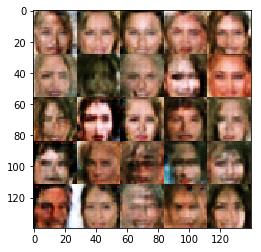

Epoch 1/1... Discriminator Loss: 1.2428... Generator Loss: 0.6418
Epoch 1/1... Discriminator Loss: 1.5908... Generator Loss: 0.5200
Epoch 1/1... Discriminator Loss: 1.0737... Generator Loss: 0.9578
Epoch 1/1... Discriminator Loss: 1.3409... Generator Loss: 0.6836
Epoch 1/1... Discriminator Loss: 1.2534... Generator Loss: 0.6747
Epoch 1/1... Discriminator Loss: 1.4057... Generator Loss: 0.5957
Epoch 1/1... Discriminator Loss: 1.3221... Generator Loss: 0.6728
Epoch 1/1... Discriminator Loss: 1.3860... Generator Loss: 0.7158
Epoch 1/1... Discriminator Loss: 1.1350... Generator Loss: 0.7942
Epoch 1/1... Discriminator Loss: 1.3081... Generator Loss: 0.6849


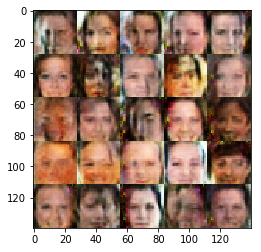

Epoch 1/1... Discriminator Loss: 1.4471... Generator Loss: 0.6468
Epoch 1/1... Discriminator Loss: 1.7285... Generator Loss: 0.4826
Epoch 1/1... Discriminator Loss: 1.2358... Generator Loss: 0.7058
Epoch 1/1... Discriminator Loss: 1.3438... Generator Loss: 0.6532
Epoch 1/1... Discriminator Loss: 1.3585... Generator Loss: 0.5770
Epoch 1/1... Discriminator Loss: 1.3318... Generator Loss: 0.7424
Epoch 1/1... Discriminator Loss: 1.3009... Generator Loss: 0.6304
Epoch 1/1... Discriminator Loss: 1.3338... Generator Loss: 0.6976
Epoch 1/1... Discriminator Loss: 1.3303... Generator Loss: 0.5342
Epoch 1/1... Discriminator Loss: 1.4574... Generator Loss: 0.7177


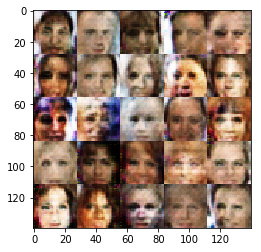

Epoch 1/1... Discriminator Loss: 1.4192... Generator Loss: 0.6938
Epoch 1/1... Discriminator Loss: 1.4680... Generator Loss: 0.5550
Epoch 1/1... Discriminator Loss: 1.3521... Generator Loss: 0.7888
Epoch 1/1... Discriminator Loss: 1.3644... Generator Loss: 0.5017
Epoch 1/1... Discriminator Loss: 1.4460... Generator Loss: 0.5061
Epoch 1/1... Discriminator Loss: 1.5549... Generator Loss: 0.4442
Epoch 1/1... Discriminator Loss: 1.2518... Generator Loss: 0.6792
Epoch 1/1... Discriminator Loss: 1.3703... Generator Loss: 0.6487
Epoch 1/1... Discriminator Loss: 1.4461... Generator Loss: 0.5581
Epoch 1/1... Discriminator Loss: 1.3995... Generator Loss: 0.6600


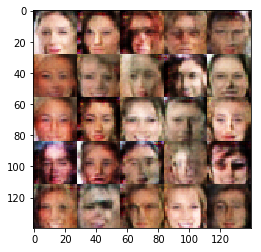

Epoch 1/1... Discriminator Loss: 1.3333... Generator Loss: 0.8233
Epoch 1/1... Discriminator Loss: 1.1957... Generator Loss: 0.7410
Epoch 1/1... Discriminator Loss: 1.2842... Generator Loss: 0.7007
Epoch 1/1... Discriminator Loss: 1.4321... Generator Loss: 0.6332
Epoch 1/1... Discriminator Loss: 1.3804... Generator Loss: 0.4816
Epoch 1/1... Discriminator Loss: 1.3292... Generator Loss: 0.8493
Epoch 1/1... Discriminator Loss: 1.4204... Generator Loss: 0.5536
Epoch 1/1... Discriminator Loss: 1.3401... Generator Loss: 0.7840
Epoch 1/1... Discriminator Loss: 1.3141... Generator Loss: 0.9201
Epoch 1/1... Discriminator Loss: 1.2895... Generator Loss: 0.6623


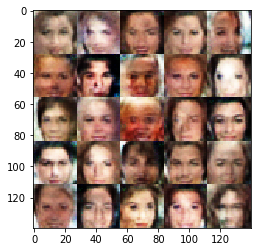

Epoch 1/1... Discriminator Loss: 1.3622... Generator Loss: 0.8277
Epoch 1/1... Discriminator Loss: 1.3887... Generator Loss: 0.6087
Epoch 1/1... Discriminator Loss: 1.3286... Generator Loss: 0.6081
Epoch 1/1... Discriminator Loss: 1.3398... Generator Loss: 0.7041
Epoch 1/1... Discriminator Loss: 1.2796... Generator Loss: 0.7676
Epoch 1/1... Discriminator Loss: 1.2935... Generator Loss: 0.6611
Epoch 1/1... Discriminator Loss: 1.3418... Generator Loss: 0.6232
Epoch 1/1... Discriminator Loss: 1.1897... Generator Loss: 1.1159
Epoch 1/1... Discriminator Loss: 1.5549... Generator Loss: 0.4588
Epoch 1/1... Discriminator Loss: 1.3654... Generator Loss: 0.5826


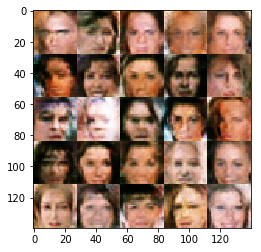

Epoch 1/1... Discriminator Loss: 1.1348... Generator Loss: 1.0006
Epoch 1/1... Discriminator Loss: 1.3581... Generator Loss: 1.0404
Epoch 1/1... Discriminator Loss: 1.4035... Generator Loss: 0.6323
Epoch 1/1... Discriminator Loss: 1.1429... Generator Loss: 0.8814
Epoch 1/1... Discriminator Loss: 1.5658... Generator Loss: 0.5899
Epoch 1/1... Discriminator Loss: 1.3546... Generator Loss: 0.7589
Epoch 1/1... Discriminator Loss: 1.4469... Generator Loss: 0.7364
Epoch 1/1... Discriminator Loss: 1.2975... Generator Loss: 0.6002
Epoch 1/1... Discriminator Loss: 1.2411... Generator Loss: 0.6490
Epoch 1/1... Discriminator Loss: 1.2731... Generator Loss: 0.6953


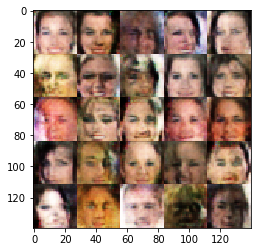

Epoch 1/1... Discriminator Loss: 1.3848... Generator Loss: 0.6190
Epoch 1/1... Discriminator Loss: 1.2080... Generator Loss: 0.7810
Epoch 1/1... Discriminator Loss: 1.3270... Generator Loss: 0.6377
Epoch 1/1... Discriminator Loss: 1.2876... Generator Loss: 0.6759
Epoch 1/1... Discriminator Loss: 1.3213... Generator Loss: 0.6922
Epoch 1/1... Discriminator Loss: 1.1778... Generator Loss: 1.1005
Epoch 1/1... Discriminator Loss: 1.3976... Generator Loss: 0.4806
Epoch 1/1... Discriminator Loss: 1.2871... Generator Loss: 0.5545
Epoch 1/1... Discriminator Loss: 1.4070... Generator Loss: 0.5082
Epoch 1/1... Discriminator Loss: 1.4090... Generator Loss: 0.6768


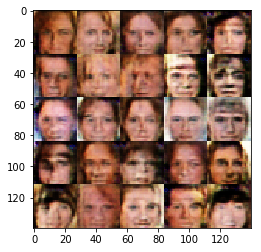

Epoch 1/1... Discriminator Loss: 1.3439... Generator Loss: 0.5708
Epoch 1/1... Discriminator Loss: 1.4065... Generator Loss: 0.6691
Epoch 1/1... Discriminator Loss: 1.2206... Generator Loss: 0.7269
Epoch 1/1... Discriminator Loss: 1.2972... Generator Loss: 0.6894
Epoch 1/1... Discriminator Loss: 1.5265... Generator Loss: 0.6257
Epoch 1/1... Discriminator Loss: 1.3387... Generator Loss: 0.5857
Epoch 1/1... Discriminator Loss: 1.5101... Generator Loss: 0.6270
Epoch 1/1... Discriminator Loss: 1.2662... Generator Loss: 0.7794
Epoch 1/1... Discriminator Loss: 1.0651... Generator Loss: 0.9442
Epoch 1/1... Discriminator Loss: 1.5117... Generator Loss: 0.7953


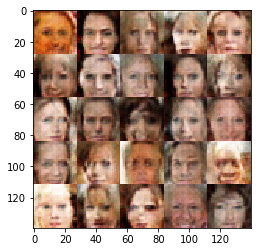

Epoch 1/1... Discriminator Loss: 1.3050... Generator Loss: 0.6823
Epoch 1/1... Discriminator Loss: 1.3225... Generator Loss: 0.6099
Epoch 1/1... Discriminator Loss: 1.3585... Generator Loss: 0.6551
Epoch 1/1... Discriminator Loss: 1.2628... Generator Loss: 0.5939
Epoch 1/1... Discriminator Loss: 1.2994... Generator Loss: 0.5920
Epoch 1/1... Discriminator Loss: 1.2130... Generator Loss: 0.8244
Epoch 1/1... Discriminator Loss: 1.4181... Generator Loss: 0.5464
Epoch 1/1... Discriminator Loss: 1.4068... Generator Loss: 0.6877
Epoch 1/1... Discriminator Loss: 1.2754... Generator Loss: 0.8775
Epoch 1/1... Discriminator Loss: 1.5927... Generator Loss: 0.6204


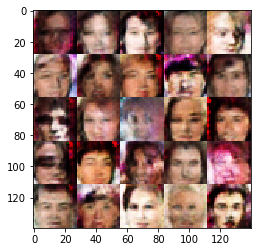

Epoch 1/1... Discriminator Loss: 1.3212... Generator Loss: 0.6043
Epoch 1/1... Discriminator Loss: 1.5010... Generator Loss: 0.4676
Epoch 1/1... Discriminator Loss: 1.2527... Generator Loss: 0.6649
Epoch 1/1... Discriminator Loss: 1.3271... Generator Loss: 0.7703
Epoch 1/1... Discriminator Loss: 1.4542... Generator Loss: 0.8293
Epoch 1/1... Discriminator Loss: 1.1753... Generator Loss: 0.7799
Epoch 1/1... Discriminator Loss: 1.2424... Generator Loss: 0.9149
Epoch 1/1... Discriminator Loss: 1.2051... Generator Loss: 0.7037
Epoch 1/1... Discriminator Loss: 1.3406... Generator Loss: 0.6656
Epoch 1/1... Discriminator Loss: 1.2537... Generator Loss: 0.7642


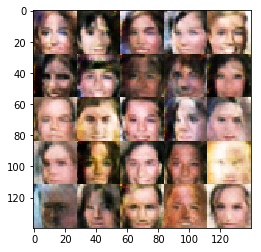

Epoch 1/1... Discriminator Loss: 1.3701... Generator Loss: 0.6550
Epoch 1/1... Discriminator Loss: 1.4155... Generator Loss: 0.5483
Epoch 1/1... Discriminator Loss: 1.2580... Generator Loss: 0.6716
Epoch 1/1... Discriminator Loss: 1.3129... Generator Loss: 0.6435
Epoch 1/1... Discriminator Loss: 1.2704... Generator Loss: 0.6447
Epoch 1/1... Discriminator Loss: 1.2674... Generator Loss: 0.7120
Epoch 1/1... Discriminator Loss: 1.1686... Generator Loss: 0.7724
Epoch 1/1... Discriminator Loss: 1.3751... Generator Loss: 0.6638
Epoch 1/1... Discriminator Loss: 1.1630... Generator Loss: 0.8516
Epoch 1/1... Discriminator Loss: 1.3529... Generator Loss: 0.7265


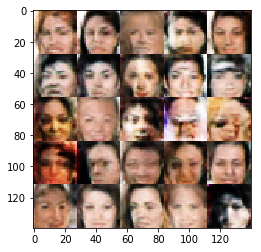

Epoch 1/1... Discriminator Loss: 1.1555... Generator Loss: 0.9646
Epoch 1/1... Discriminator Loss: 1.3198... Generator Loss: 0.6391
Epoch 1/1... Discriminator Loss: 1.5640... Generator Loss: 0.4195
Epoch 1/1... Discriminator Loss: 1.2951... Generator Loss: 0.7535
Epoch 1/1... Discriminator Loss: 1.2704... Generator Loss: 0.7593
Epoch 1/1... Discriminator Loss: 1.3484... Generator Loss: 0.5780
Epoch 1/1... Discriminator Loss: 1.3867... Generator Loss: 0.6160
Epoch 1/1... Discriminator Loss: 1.3043... Generator Loss: 0.7769
Epoch 1/1... Discriminator Loss: 1.3823... Generator Loss: 0.6697
Epoch 1/1... Discriminator Loss: 1.3477... Generator Loss: 0.6436


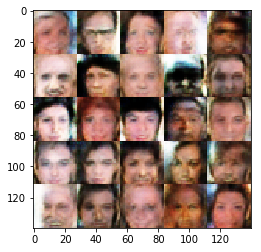

Epoch 1/1... Discriminator Loss: 1.6244... Generator Loss: 0.4868
Epoch 1/1... Discriminator Loss: 1.3199... Generator Loss: 0.6913
Epoch 1/1... Discriminator Loss: 1.4103... Generator Loss: 0.6058
Epoch 1/1... Discriminator Loss: 1.2350... Generator Loss: 0.6905
Epoch 1/1... Discriminator Loss: 1.1884... Generator Loss: 0.6628
Epoch 1/1... Discriminator Loss: 1.0985... Generator Loss: 0.8319
Epoch 1/1... Discriminator Loss: 1.4683... Generator Loss: 0.5355
Epoch 1/1... Discriminator Loss: 1.3876... Generator Loss: 0.7028
Epoch 1/1... Discriminator Loss: 1.2828... Generator Loss: 0.7233
Epoch 1/1... Discriminator Loss: 1.1632... Generator Loss: 0.8010


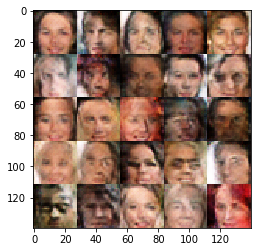

Epoch 1/1... Discriminator Loss: 1.2380... Generator Loss: 0.7383
Epoch 1/1... Discriminator Loss: 1.3875... Generator Loss: 0.6372
Epoch 1/1... Discriminator Loss: 1.2344... Generator Loss: 0.8093
Epoch 1/1... Discriminator Loss: 1.3679... Generator Loss: 0.5541
Epoch 1/1... Discriminator Loss: 1.4751... Generator Loss: 0.6841
Epoch 1/1... Discriminator Loss: 0.9388... Generator Loss: 1.0585
Epoch 1/1... Discriminator Loss: 1.2168... Generator Loss: 0.8120
Epoch 1/1... Discriminator Loss: 1.1820... Generator Loss: 0.6792
Epoch 1/1... Discriminator Loss: 1.5378... Generator Loss: 1.0337
Epoch 1/1... Discriminator Loss: 1.2861... Generator Loss: 0.7712


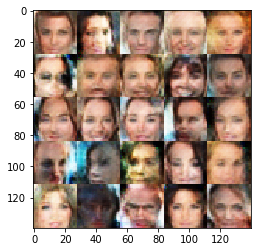

Epoch 1/1... Discriminator Loss: 1.3330... Generator Loss: 0.7987
Epoch 1/1... Discriminator Loss: 1.1021... Generator Loss: 1.0144
Epoch 1/1... Discriminator Loss: 1.3536... Generator Loss: 0.5785
Epoch 1/1... Discriminator Loss: 1.3337... Generator Loss: 0.6337
Epoch 1/1... Discriminator Loss: 1.3692... Generator Loss: 0.6034
Epoch 1/1... Discriminator Loss: 1.2042... Generator Loss: 0.6937
Epoch 1/1... Discriminator Loss: 1.3728... Generator Loss: 0.4885
Epoch 1/1... Discriminator Loss: 1.2839... Generator Loss: 0.6239
Epoch 1/1... Discriminator Loss: 1.4048... Generator Loss: 0.7395
Epoch 1/1... Discriminator Loss: 1.3279... Generator Loss: 0.7314


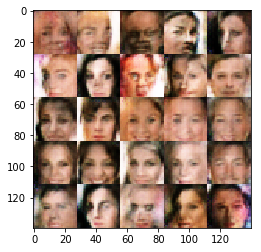

Epoch 1/1... Discriminator Loss: 1.3773... Generator Loss: 0.7608
Epoch 1/1... Discriminator Loss: 1.3070... Generator Loss: 0.6905
Epoch 1/1... Discriminator Loss: 1.3362... Generator Loss: 0.6644
Epoch 1/1... Discriminator Loss: 1.3116... Generator Loss: 0.6731
Epoch 1/1... Discriminator Loss: 1.3162... Generator Loss: 0.6291
Epoch 1/1... Discriminator Loss: 1.2198... Generator Loss: 0.7190
Epoch 1/1... Discriminator Loss: 1.2694... Generator Loss: 0.6498
Epoch 1/1... Discriminator Loss: 1.2528... Generator Loss: 0.6383
Epoch 1/1... Discriminator Loss: 1.4417... Generator Loss: 0.6452
Epoch 1/1... Discriminator Loss: 1.3629... Generator Loss: 0.5858


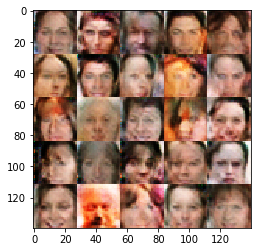

Epoch 1/1... Discriminator Loss: 1.4060... Generator Loss: 0.5287
Epoch 1/1... Discriminator Loss: 1.3728... Generator Loss: 0.5618
Epoch 1/1... Discriminator Loss: 1.3191... Generator Loss: 0.8626
Epoch 1/1... Discriminator Loss: 1.3133... Generator Loss: 0.7354
Epoch 1/1... Discriminator Loss: 1.3354... Generator Loss: 0.6644
Epoch 1/1... Discriminator Loss: 1.3050... Generator Loss: 0.8557
Epoch 1/1... Discriminator Loss: 1.4316... Generator Loss: 0.5808
Epoch 1/1... Discriminator Loss: 1.3882... Generator Loss: 0.8403
Epoch 1/1... Discriminator Loss: 1.3455... Generator Loss: 0.6354
Epoch 1/1... Discriminator Loss: 1.3216... Generator Loss: 0.6766


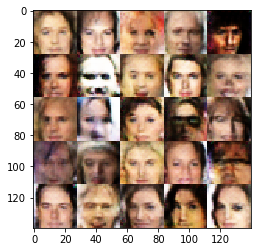

Epoch 1/1... Discriminator Loss: 1.2266... Generator Loss: 0.7314
Epoch 1/1... Discriminator Loss: 1.4317... Generator Loss: 0.4562
Epoch 1/1... Discriminator Loss: 1.4285... Generator Loss: 1.0014
Epoch 1/1... Discriminator Loss: 1.4631... Generator Loss: 0.4213
Epoch 1/1... Discriminator Loss: 1.3342... Generator Loss: 0.8402
Epoch 1/1... Discriminator Loss: 1.4337... Generator Loss: 0.6057
Epoch 1/1... Discriminator Loss: 1.4325... Generator Loss: 0.6869
Epoch 1/1... Discriminator Loss: 1.2946... Generator Loss: 0.4590
Epoch 1/1... Discriminator Loss: 1.2916... Generator Loss: 0.8046
Epoch 1/1... Discriminator Loss: 1.3498... Generator Loss: 0.7974


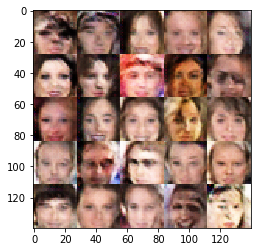

Epoch 1/1... Discriminator Loss: 1.1636... Generator Loss: 0.8954
Epoch 1/1... Discriminator Loss: 1.2765... Generator Loss: 0.8266
Epoch 1/1... Discriminator Loss: 1.1924... Generator Loss: 0.9724
Epoch 1/1... Discriminator Loss: 1.3459... Generator Loss: 0.6898
Epoch 1/1... Discriminator Loss: 1.5140... Generator Loss: 0.5047
Epoch 1/1... Discriminator Loss: 1.2429... Generator Loss: 0.7060
Epoch 1/1... Discriminator Loss: 1.1944... Generator Loss: 0.8594
Epoch 1/1... Discriminator Loss: 1.3315... Generator Loss: 0.8985
Epoch 1/1... Discriminator Loss: 1.4181... Generator Loss: 0.6167
Epoch 1/1... Discriminator Loss: 1.4027... Generator Loss: 0.5783


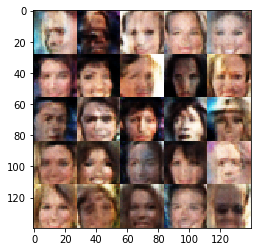

Epoch 1/1... Discriminator Loss: 1.4880... Generator Loss: 0.6682
Epoch 1/1... Discriminator Loss: 1.4813... Generator Loss: 0.4761
Epoch 1/1... Discriminator Loss: 1.2491... Generator Loss: 0.6366
Epoch 1/1... Discriminator Loss: 1.2277... Generator Loss: 0.8465
Epoch 1/1... Discriminator Loss: 1.4254... Generator Loss: 0.5951
Epoch 1/1... Discriminator Loss: 1.3385... Generator Loss: 0.6502
Epoch 1/1... Discriminator Loss: 1.3404... Generator Loss: 0.7785
Epoch 1/1... Discriminator Loss: 1.3323... Generator Loss: 0.5625
Epoch 1/1... Discriminator Loss: 1.3924... Generator Loss: 0.6932
Epoch 1/1... Discriminator Loss: 1.3273... Generator Loss: 0.7995


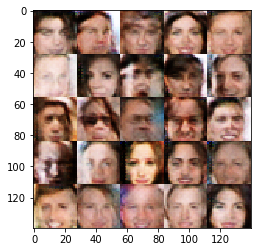

Epoch 1/1... Discriminator Loss: 1.3557... Generator Loss: 0.5544
Epoch 1/1... Discriminator Loss: 1.2735... Generator Loss: 0.6942
Epoch 1/1... Discriminator Loss: 1.4435... Generator Loss: 0.5518
Epoch 1/1... Discriminator Loss: 1.4193... Generator Loss: 0.6665
Epoch 1/1... Discriminator Loss: 1.2751... Generator Loss: 0.7552
Epoch 1/1... Discriminator Loss: 1.5152... Generator Loss: 0.5450
Epoch 1/1... Discriminator Loss: 1.3521... Generator Loss: 0.5672
Epoch 1/1... Discriminator Loss: 1.3975... Generator Loss: 0.7976
Epoch 1/1... Discriminator Loss: 1.3710... Generator Loss: 0.6726
Epoch 1/1... Discriminator Loss: 1.2655... Generator Loss: 0.8686


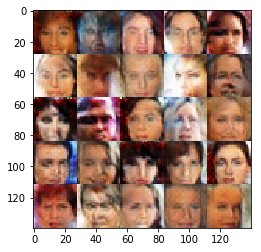

Epoch 1/1... Discriminator Loss: 1.2560... Generator Loss: 0.8186
Epoch 1/1... Discriminator Loss: 1.3236... Generator Loss: 0.7185
Epoch 1/1... Discriminator Loss: 1.3012... Generator Loss: 0.6672
Epoch 1/1... Discriminator Loss: 1.3591... Generator Loss: 0.6076
Epoch 1/1... Discriminator Loss: 1.3620... Generator Loss: 0.6353
Epoch 1/1... Discriminator Loss: 1.4096... Generator Loss: 0.6407
Epoch 1/1... Discriminator Loss: 1.1787... Generator Loss: 0.8442
Epoch 1/1... Discriminator Loss: 1.3259... Generator Loss: 0.5948
Epoch 1/1... Discriminator Loss: 1.4296... Generator Loss: 0.5746
Epoch 1/1... Discriminator Loss: 1.2488... Generator Loss: 0.6851


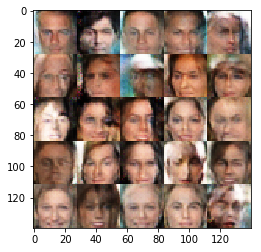

Epoch 1/1... Discriminator Loss: 1.3246... Generator Loss: 0.6551
Epoch 1/1... Discriminator Loss: 1.2593... Generator Loss: 0.6257
Epoch 1/1... Discriminator Loss: 1.2321... Generator Loss: 0.6964
Epoch 1/1... Discriminator Loss: 1.2630... Generator Loss: 0.6416
Epoch 1/1... Discriminator Loss: 1.2232... Generator Loss: 0.7217
Epoch 1/1... Discriminator Loss: 1.2731... Generator Loss: 0.6364
Epoch 1/1... Discriminator Loss: 1.2963... Generator Loss: 0.7636
Epoch 1/1... Discriminator Loss: 1.3841... Generator Loss: 0.5627
Epoch 1/1... Discriminator Loss: 1.2982... Generator Loss: 0.7189
Epoch 1/1... Discriminator Loss: 1.3254... Generator Loss: 0.8864


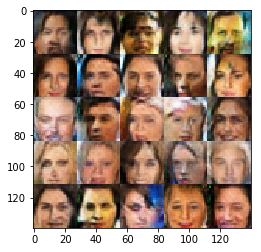

Epoch 1/1... Discriminator Loss: 1.3894... Generator Loss: 0.7020
Epoch 1/1... Discriminator Loss: 1.3165... Generator Loss: 0.7669
Epoch 1/1... Discriminator Loss: 1.4544... Generator Loss: 0.5608
Epoch 1/1... Discriminator Loss: 1.3723... Generator Loss: 0.5127
Epoch 1/1... Discriminator Loss: 1.3920... Generator Loss: 0.6472
Epoch 1/1... Discriminator Loss: 1.3246... Generator Loss: 0.7644
Epoch 1/1... Discriminator Loss: 1.3305... Generator Loss: 0.7191
Epoch 1/1... Discriminator Loss: 1.2954... Generator Loss: 0.7200
Epoch 1/1... Discriminator Loss: 1.3388... Generator Loss: 0.6973
Epoch 1/1... Discriminator Loss: 1.3501... Generator Loss: 0.6703


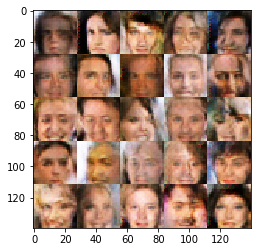

Epoch 1/1... Discriminator Loss: 1.6349... Generator Loss: 0.7350
Epoch 1/1... Discriminator Loss: 1.3375... Generator Loss: 0.6281
Epoch 1/1... Discriminator Loss: 1.5021... Generator Loss: 0.6965
Epoch 1/1... Discriminator Loss: 1.3001... Generator Loss: 0.7408
Epoch 1/1... Discriminator Loss: 1.3476... Generator Loss: 0.6092
Epoch 1/1... Discriminator Loss: 1.3440... Generator Loss: 0.7391
Epoch 1/1... Discriminator Loss: 1.3699... Generator Loss: 0.7101
Epoch 1/1... Discriminator Loss: 1.3826... Generator Loss: 0.5529
Epoch 1/1... Discriminator Loss: 1.4591... Generator Loss: 0.6876
Epoch 1/1... Discriminator Loss: 1.3130... Generator Loss: 0.6905


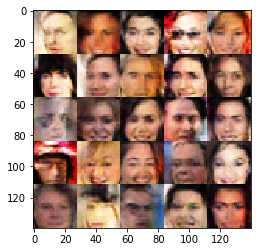

Epoch 1/1... Discriminator Loss: 1.3805... Generator Loss: 0.5358
Epoch 1/1... Discriminator Loss: 1.2502... Generator Loss: 0.7037
Epoch 1/1... Discriminator Loss: 1.4597... Generator Loss: 0.6243
Epoch 1/1... Discriminator Loss: 1.2557... Generator Loss: 0.7173
Epoch 1/1... Discriminator Loss: 1.3935... Generator Loss: 0.6565
Epoch 1/1... Discriminator Loss: 1.1811... Generator Loss: 0.7630
Epoch 1/1... Discriminator Loss: 1.3772... Generator Loss: 0.6544
Epoch 1/1... Discriminator Loss: 1.2803... Generator Loss: 0.6951
Epoch 1/1... Discriminator Loss: 1.4317... Generator Loss: 0.6889
Epoch 1/1... Discriminator Loss: 1.2139... Generator Loss: 0.7051


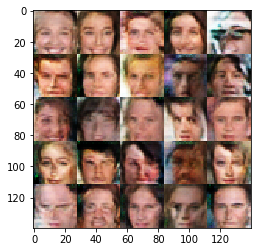

Epoch 1/1... Discriminator Loss: 1.3402... Generator Loss: 0.7139
Epoch 1/1... Discriminator Loss: 1.3724... Generator Loss: 0.8226
Epoch 1/1... Discriminator Loss: 1.4035... Generator Loss: 0.5783
Epoch 1/1... Discriminator Loss: 1.3833... Generator Loss: 0.6995
Epoch 1/1... Discriminator Loss: 1.2831... Generator Loss: 0.6997
Epoch 1/1... Discriminator Loss: 1.3800... Generator Loss: 0.5383
Epoch 1/1... Discriminator Loss: 1.4708... Generator Loss: 0.5482
Epoch 1/1... Discriminator Loss: 1.3478... Generator Loss: 0.6098
Epoch 1/1... Discriminator Loss: 1.3970... Generator Loss: 0.7042
Epoch 1/1... Discriminator Loss: 1.3657... Generator Loss: 0.7198


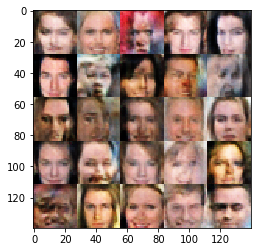

Epoch 1/1... Discriminator Loss: 1.3872... Generator Loss: 0.6962
Epoch 1/1... Discriminator Loss: 1.3118... Generator Loss: 0.6167
Epoch 1/1... Discriminator Loss: 1.3521... Generator Loss: 0.6143
Epoch 1/1... Discriminator Loss: 1.3856... Generator Loss: 0.6736
Epoch 1/1... Discriminator Loss: 1.3302... Generator Loss: 0.6804
Epoch 1/1... Discriminator Loss: 1.4035... Generator Loss: 0.7737
Epoch 1/1... Discriminator Loss: 1.4396... Generator Loss: 0.5369
Epoch 1/1... Discriminator Loss: 1.2750... Generator Loss: 0.6966
Epoch 1/1... Discriminator Loss: 1.3151... Generator Loss: 0.8065
Epoch 1/1... Discriminator Loss: 1.5028... Generator Loss: 0.5712


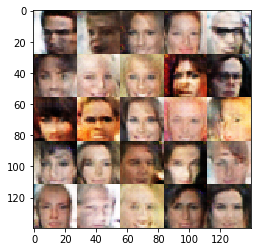

Epoch 1/1... Discriminator Loss: 1.2641... Generator Loss: 0.7186
Epoch 1/1... Discriminator Loss: 1.3814... Generator Loss: 0.5266
Epoch 1/1... Discriminator Loss: 1.4116... Generator Loss: 0.6598
Epoch 1/1... Discriminator Loss: 1.3463... Generator Loss: 0.6755
Epoch 1/1... Discriminator Loss: 1.4314... Generator Loss: 0.7903
Epoch 1/1... Discriminator Loss: 1.4861... Generator Loss: 0.5948
Epoch 1/1... Discriminator Loss: 1.4373... Generator Loss: 0.5479
Epoch 1/1... Discriminator Loss: 1.2787... Generator Loss: 0.6524
Epoch 1/1... Discriminator Loss: 1.3654... Generator Loss: 0.6818
Epoch 1/1... Discriminator Loss: 1.3566... Generator Loss: 0.7659


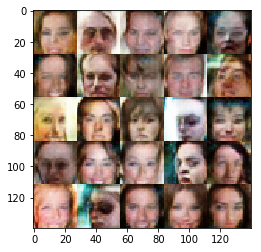

Epoch 1/1... Discriminator Loss: 1.3384... Generator Loss: 0.6808
Epoch 1/1... Discriminator Loss: 1.1980... Generator Loss: 0.7857
Epoch 1/1... Discriminator Loss: 1.2960... Generator Loss: 0.7313
Epoch 1/1... Discriminator Loss: 1.4095... Generator Loss: 0.5931
Epoch 1/1... Discriminator Loss: 1.2811... Generator Loss: 0.8217
Epoch 1/1... Discriminator Loss: 1.3304... Generator Loss: 0.7124
Epoch 1/1... Discriminator Loss: 1.3039... Generator Loss: 0.5860
Epoch 1/1... Discriminator Loss: 1.3199... Generator Loss: 0.7145
Epoch 1/1... Discriminator Loss: 1.2560... Generator Loss: 0.7385
Epoch 1/1... Discriminator Loss: 1.4075... Generator Loss: 0.5771


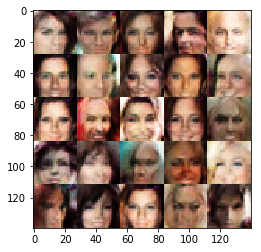

Epoch 1/1... Discriminator Loss: 1.2642... Generator Loss: 0.7503
Epoch 1/1... Discriminator Loss: 1.3055... Generator Loss: 0.7515
Epoch 1/1... Discriminator Loss: 1.3472... Generator Loss: 0.6965
Epoch 1/1... Discriminator Loss: 1.3933... Generator Loss: 0.7415
Epoch 1/1... Discriminator Loss: 1.2793... Generator Loss: 0.7705
Epoch 1/1... Discriminator Loss: 1.3718... Generator Loss: 0.6158
Epoch 1/1... Discriminator Loss: 1.3698... Generator Loss: 0.6552
Epoch 1/1... Discriminator Loss: 1.3494... Generator Loss: 0.5093
Epoch 1/1... Discriminator Loss: 1.2802... Generator Loss: 0.6628
Epoch 1/1... Discriminator Loss: 1.2787... Generator Loss: 0.6314


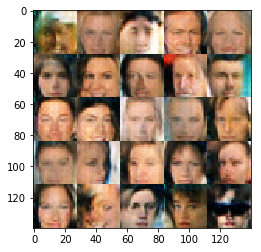

Epoch 1/1... Discriminator Loss: 1.4731... Generator Loss: 0.6322
Epoch 1/1... Discriminator Loss: 1.4566... Generator Loss: 0.5818
Epoch 1/1... Discriminator Loss: 1.3749... Generator Loss: 0.6667
Epoch 1/1... Discriminator Loss: 1.3080... Generator Loss: 0.5933
Epoch 1/1... Discriminator Loss: 1.3461... Generator Loss: 0.7326
Epoch 1/1... Discriminator Loss: 1.2409... Generator Loss: 0.7887
Epoch 1/1... Discriminator Loss: 1.3621... Generator Loss: 0.5454
Epoch 1/1... Discriminator Loss: 1.3515... Generator Loss: 0.5630
Epoch 1/1... Discriminator Loss: 1.2701... Generator Loss: 0.6924
Epoch 1/1... Discriminator Loss: 1.4628... Generator Loss: 0.5496


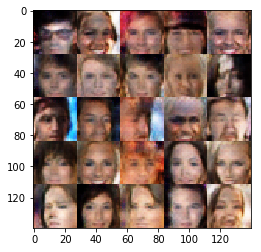

Epoch 1/1... Discriminator Loss: 1.2781... Generator Loss: 0.7103
Epoch 1/1... Discriminator Loss: 1.2278... Generator Loss: 0.8248
Epoch 1/1... Discriminator Loss: 1.3873... Generator Loss: 0.5627
Epoch 1/1... Discriminator Loss: 1.4354... Generator Loss: 0.5207
Epoch 1/1... Discriminator Loss: 1.4392... Generator Loss: 0.5567
Epoch 1/1... Discriminator Loss: 1.4047... Generator Loss: 0.5953
Epoch 1/1... Discriminator Loss: 1.3946... Generator Loss: 0.6402
Epoch 1/1... Discriminator Loss: 1.3115... Generator Loss: 0.6543
Epoch 1/1... Discriminator Loss: 1.3904... Generator Loss: 0.7471
Epoch 1/1... Discriminator Loss: 1.4182... Generator Loss: 0.6165


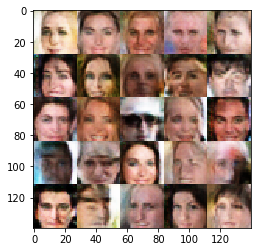

Epoch 1/1... Discriminator Loss: 1.2766... Generator Loss: 0.7789
Epoch 1/1... Discriminator Loss: 1.3461... Generator Loss: 0.7545
Epoch 1/1... Discriminator Loss: 1.3644... Generator Loss: 0.7324
Epoch 1/1... Discriminator Loss: 1.2386... Generator Loss: 0.7110
Epoch 1/1... Discriminator Loss: 1.3981... Generator Loss: 0.5961
Epoch 1/1... Discriminator Loss: 1.3537... Generator Loss: 0.6307
Epoch 1/1... Discriminator Loss: 1.3581... Generator Loss: 0.7233
Epoch 1/1... Discriminator Loss: 1.3757... Generator Loss: 0.6426
Epoch 1/1... Discriminator Loss: 1.2691... Generator Loss: 0.7482
Epoch 1/1... Discriminator Loss: 1.3321... Generator Loss: 0.7062


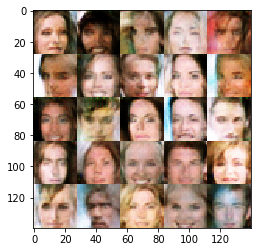

Epoch 1/1... Discriminator Loss: 1.4260... Generator Loss: 0.7673
Epoch 1/1... Discriminator Loss: 1.2886... Generator Loss: 0.7678
Epoch 1/1... Discriminator Loss: 1.3967... Generator Loss: 0.7448
Epoch 1/1... Discriminator Loss: 1.4270... Generator Loss: 0.5994
Epoch 1/1... Discriminator Loss: 1.2879... Generator Loss: 0.9195
Epoch 1/1... Discriminator Loss: 1.3239... Generator Loss: 0.9325
Epoch 1/1... Discriminator Loss: 1.3910... Generator Loss: 0.6927
Epoch 1/1... Discriminator Loss: 1.3682... Generator Loss: 0.8447
Epoch 1/1... Discriminator Loss: 1.3189... Generator Loss: 0.7523
Epoch 1/1... Discriminator Loss: 1.3443... Generator Loss: 0.7038


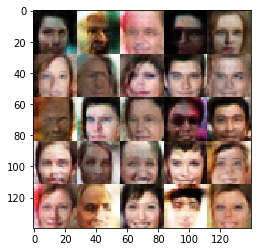

Epoch 1/1... Discriminator Loss: 1.3050... Generator Loss: 0.6585
Epoch 1/1... Discriminator Loss: 1.2410... Generator Loss: 0.6853
Epoch 1/1... Discriminator Loss: 1.3357... Generator Loss: 0.7488
Epoch 1/1... Discriminator Loss: 1.4732... Generator Loss: 0.6610
Epoch 1/1... Discriminator Loss: 1.2946... Generator Loss: 0.7626
Epoch 1/1... Discriminator Loss: 1.3414... Generator Loss: 0.6535
Epoch 1/1... Discriminator Loss: 1.4492... Generator Loss: 0.5505
Epoch 1/1... Discriminator Loss: 1.3840... Generator Loss: 0.8015
Epoch 1/1... Discriminator Loss: 1.3304... Generator Loss: 0.6455
Epoch 1/1... Discriminator Loss: 1.3034... Generator Loss: 0.7549


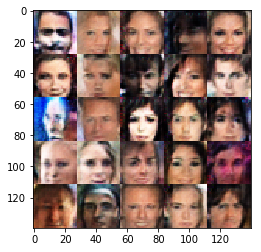

Epoch 1/1... Discriminator Loss: 1.4086... Generator Loss: 0.7549
Epoch 1/1... Discriminator Loss: 1.4011... Generator Loss: 0.6808
Epoch 1/1... Discriminator Loss: 1.4230... Generator Loss: 0.7021
Epoch 1/1... Discriminator Loss: 1.4260... Generator Loss: 0.6779
Epoch 1/1... Discriminator Loss: 1.4140... Generator Loss: 0.6237
Epoch 1/1... Discriminator Loss: 1.2544... Generator Loss: 0.7564
Epoch 1/1... Discriminator Loss: 1.2564... Generator Loss: 0.8353
Epoch 1/1... Discriminator Loss: 1.3945... Generator Loss: 0.6410
Epoch 1/1... Discriminator Loss: 1.3731... Generator Loss: 0.6203
Epoch 1/1... Discriminator Loss: 1.3050... Generator Loss: 0.6186


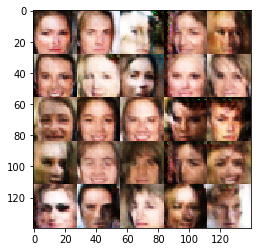

Epoch 1/1... Discriminator Loss: 1.3949... Generator Loss: 0.6728
Epoch 1/1... Discriminator Loss: 1.3283... Generator Loss: 0.6218
Epoch 1/1... Discriminator Loss: 1.2692... Generator Loss: 0.7406
Epoch 1/1... Discriminator Loss: 1.3639... Generator Loss: 0.5590
Epoch 1/1... Discriminator Loss: 1.3033... Generator Loss: 0.7199
Epoch 1/1... Discriminator Loss: 1.3847... Generator Loss: 0.6097
Epoch 1/1... Discriminator Loss: 1.3971... Generator Loss: 0.7069
Epoch 1/1... Discriminator Loss: 1.3614... Generator Loss: 0.7026
Epoch 1/1... Discriminator Loss: 1.2583... Generator Loss: 0.8067
Epoch 1/1... Discriminator Loss: 1.3808... Generator Loss: 0.5998


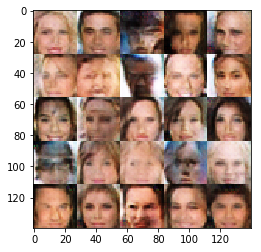

Epoch 1/1... Discriminator Loss: 1.3669... Generator Loss: 0.5973
Epoch 1/1... Discriminator Loss: 1.3471... Generator Loss: 0.6371
Epoch 1/1... Discriminator Loss: 1.3351... Generator Loss: 0.6832
Epoch 1/1... Discriminator Loss: 1.3539... Generator Loss: 0.6244
Epoch 1/1... Discriminator Loss: 1.3573... Generator Loss: 0.6105
Epoch 1/1... Discriminator Loss: 1.3446... Generator Loss: 0.6536
Epoch 1/1... Discriminator Loss: 1.3851... Generator Loss: 0.6156
Epoch 1/1... Discriminator Loss: 1.3313... Generator Loss: 0.7424
Epoch 1/1... Discriminator Loss: 1.2935... Generator Loss: 0.7114
Epoch 1/1... Discriminator Loss: 1.3129... Generator Loss: 0.7088


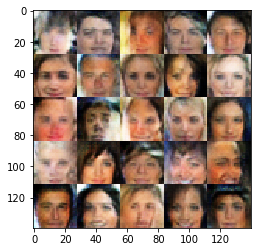

Epoch 1/1... Discriminator Loss: 1.4374... Generator Loss: 0.6510
Epoch 1/1... Discriminator Loss: 1.3237... Generator Loss: 0.8205
Epoch 1/1... Discriminator Loss: 1.4957... Generator Loss: 0.6064
Epoch 1/1... Discriminator Loss: 1.4555... Generator Loss: 0.6312
Epoch 1/1... Discriminator Loss: 1.3798... Generator Loss: 0.7801
Epoch 1/1... Discriminator Loss: 1.2947... Generator Loss: 0.6755
Epoch 1/1... Discriminator Loss: 1.3373... Generator Loss: 0.6485
Epoch 1/1... Discriminator Loss: 1.3212... Generator Loss: 0.6602
Epoch 1/1... Discriminator Loss: 1.4509... Generator Loss: 0.6491
Epoch 1/1... Discriminator Loss: 1.2861... Generator Loss: 0.6774


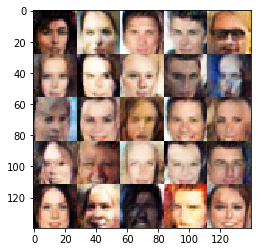

Epoch 1/1... Discriminator Loss: 1.3127... Generator Loss: 0.6313
Epoch 1/1... Discriminator Loss: 1.2130... Generator Loss: 0.7624
Epoch 1/1... Discriminator Loss: 1.3729... Generator Loss: 0.6986
Epoch 1/1... Discriminator Loss: 1.3560... Generator Loss: 0.5892
Epoch 1/1... Discriminator Loss: 1.3322... Generator Loss: 0.6328
Epoch 1/1... Discriminator Loss: 1.3283... Generator Loss: 0.7113
Epoch 1/1... Discriminator Loss: 1.3592... Generator Loss: 0.7349
Epoch 1/1... Discriminator Loss: 1.3305... Generator Loss: 0.7364
Epoch 1/1... Discriminator Loss: 1.4037... Generator Loss: 0.6441
Epoch 1/1... Discriminator Loss: 1.3919... Generator Loss: 0.5603


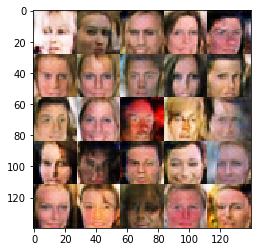

Epoch 1/1... Discriminator Loss: 1.3397... Generator Loss: 0.6140
Epoch 1/1... Discriminator Loss: 1.2977... Generator Loss: 0.6773
Epoch 1/1... Discriminator Loss: 1.3410... Generator Loss: 0.6738
Epoch 1/1... Discriminator Loss: 1.3140... Generator Loss: 0.6896
Epoch 1/1... Discriminator Loss: 1.3132... Generator Loss: 0.7702
Epoch 1/1... Discriminator Loss: 1.4100... Generator Loss: 0.5527
Epoch 1/1... Discriminator Loss: 1.4035... Generator Loss: 0.6167
Epoch 1/1... Discriminator Loss: 1.2836... Generator Loss: 0.6856
Epoch 1/1... Discriminator Loss: 1.3828... Generator Loss: 0.6209
Epoch 1/1... Discriminator Loss: 1.2849... Generator Loss: 0.5958


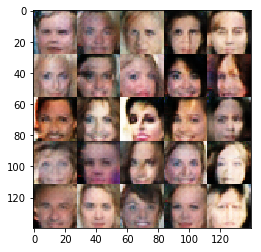

Epoch 1/1... Discriminator Loss: 1.3754... Generator Loss: 0.6803
Epoch 1/1... Discriminator Loss: 1.4524... Generator Loss: 0.6518
Epoch 1/1... Discriminator Loss: 1.3528... Generator Loss: 0.6698


In [16]:
batch_size = 32
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.